In [357]:
import pandas as pd
import matplotlib.pyplot as plt

In [358]:
import databento as db

In [359]:
import glob

In [360]:
import tqdm

In [361]:
import itertools

In [362]:
import datetime

In [67]:
!ls ../data/databento/mes/ftp.databento.com/E8XGYL35/GLBX-20241008-PP9KBLT3CX/glbx-mdp3-20240906.mbo.dbn.zst

../data/databento/mes/ftp.databento.com/E8XGYL35/GLBX-20241008-PP9KBLT3CX/glbx-mdp3-20240906.mbo.dbn.zst


# Trade Clusters

In [363]:
data = db.DBNStore.from_file('../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/glbx-mdp3-20240906.mbo.dbn.zst')
instrument_map = db.common.symbology.InstrumentMap()
instrument_map.insert_metadata(data.metadata)

In [384]:
for mbo in itertools.islice(data,0,100000):
    if abs(mbo.sequence-43834737) <= 5:
        print(mbo.instrument_id, mbo.ts_event, mbo.action, mbo.size, mbo.side, mbo.order_id, mbo.sequence)

118 1725580811172611203 T 1 A 6413773254508 43834732
118 1725580811172611203 F 1 B 6413773254395 43834732
118 1725580811172611203 C 1 B 6413773254395 43834733
118 1725580811172775509 M 1 A 6413773254443 43834734
118 1725580811172794613 T 1 A 6413773254509 43834735
118 1725580811172794613 F 1 B 6413773254400 43834735
118 1725580811172794613 C 1 B 6413773254400 43834736
118 1725580811172799355 T 2 A 6413773254510 43834736
118 1725580811172799355 F 1 B 6413773254414 43834736
118 1725580811172799355 F 1 B 6413773254418 43834736
118 1725580811172799355 C 1 B 6413773254414 43834736
118 1725580811172799355 M 15 B 6413773254418 43834736
118 1725580811172805325 A 1 A 6413773254511 43834736
183748 1725580811172800199 C 1 B 6413773254409 43834736
183748 1725580811172800757 C 1 B 6413773254411 43834736
118 1725580811172829919 T 1 A 6413773254513 43834737
118 1725580811172829919 F 1 B 6413773254418 43834737
118 1725580811172829919 M 14 B 6413773254418 43834737
118 1725580811172837445 T 14 A 6413773

In [399]:
from collections import defaultdict
fills_by_trade = defaultdict(int)
cancels_by_trade = defaultdict(int)
original_order_size = {}

# To hold current trade details
current_trade_details = {}

# Process each event
for event in data:
    if event.action == 'T':
        # Store the trade event details
        current_trade_details[event.order_id] = {
            'size': event.size,
            'side': event.side,
            'sequence': event.sequence,
            'order_id': event.order_id
        }
        original_order_size[event.order_id] = event.size  # Initialize original size
    elif event.action == 'F':
        trade_details = current_trade_details.get(event.order_id)
        if trade_details:
            # Ignore fills that match the trade size, order ID, and side
            if (event.size == trade_details['size'] and
                event.order_id == trade_details['order_id'] and
                event.side == trade_details['side']):
                continue  # Ignore this fill
            fills_by_trade[event.order_id] += event.size
    elif event.action == 'C':
        trade_details = current_trade_details.get(event.order_id)
        if trade_details:
            cancels_by_trade[event.order_id] += event.size
    elif event.action == 'M':
        if event.order_id in original_order_size:
            removed_amount = original_order_size[event.order_id] - event.size
            original_order_size[event.order_id] = event.size
            cancels_by_trade[event.order_id] += removed_amount

    # Validation for trade events
    if event.action == 'T':
        total_fills = fills_by_trade[event.order_id]
        assert total_fills <= current_trade_details[event.order_id]['size'], (
            f"Validation error for trade {event.order_id} (seq {event.sequence}): "
            f"Expected fills <= trade size ({current_trade_details[event.order_id]['size']}), Actual fills = {total_fills}"
        )

        total_cancels = cancels_by_trade[event.order_id]
        assert total_cancels <= current_trade_details[event.order_id]['size'], (
            f"Validation error for trade {event.order_id} (seq {event.sequence}): "
            f"Expected cancels <= trade size ({current_trade_details[event.order_id]['size']}), Actual cancels = {total_cancels}"
        )

AssertionError: Validation error for trade 6413773297380 (seq 43935888): Expected fills <= trade size (11), Actual fills = 13

In [397]:
for mbo in data:
    if abs(mbo.sequence-43935888)<=5:
        print(mbo.instrument_id, mbo.ts_event, mbo.action, mbo.size, mbo.side, mbo.order_id, mbo.sequence)

5002 1725582268035279479 M 1 B 6413773239341 43935883
118 1725582268037314033 A 1 A 6413773299634 43935884
118 1725582268037551891 C 1 A 6413773299634 43935885
118 1725582268126532735 A 1 B 6413773299635 43935886
118 1725582268126650829 A 1 B 6413773299636 43935887
118 1725582268593057971 T 11 A 6413773297380 43935888
118 1725582268593057971 F 11 A 6413773297380 43935888
118 1725582268593057971 F 4 B 6413773299471 43935888
118 1725582268593057971 F 2 B 6413773299539 43935888
118 1725582268593057971 F 1 B 6413773299588 43935888
118 1725582268593057971 F 1 B 6413773299592 43935888
118 1725582268593057971 F 1 B 6413773299595 43935888
118 1725582268593057971 F 1 B 6413773299599 43935888
118 1725582268593057971 F 1 B 6413773299602 43935888
118 1725582268593057971 C 4 B 6413773299471 43935889
118 1725582268593057971 C 2 B 6413773299539 43935889
118 1725582268593057971 C 1 B 6413773299588 43935889
118 1725582268593057971 C 1 B 6413773299592 43935889
118 1725582268593057971 C 1 B 6413773299595

In [180]:
filled_orders = set()
for mbo in tqdm.tqdm(data):
    instrument = instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_recv*1e-9).date())
    if instrument == 'ESU4':
        if mbo.order_id == 6413773252545:
            print(mbo)

142317it [00:00, 643364.59it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725580799928189511 }, order_id: 6413773252545, price: 5509.750000000, size: 1, flags: SNAPSHOT | BAD_TS_RECV (40), channel_id: 0, action: 'A', side: 'B', ts_recv: 1725580800000000000, ts_in_delta: 0, sequence: 43830845 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725580800003546257 }, order_id: 6413773252545, price: 5509.750000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725580800003652921, ts_in_delta: 12473, sequence: 43830870 }


21682781it [00:28, 772195.11it/s]


In [186]:
from collections import Counter

In [201]:
prev_action = None
actions = set()
bigrams = Counter()
for mbo in tqdm.tqdm(data):
    instrument = instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_recv*1e-9).date())
    if instrument == 'ESU4':
        actions.add(mbo.action)
        bigrams.update([(prev_action,mbo.action)])
        prev_action = mbo.action

21682781it [00:34, 636989.96it/s]


In [202]:
for a in actions:
    for b in actions:
        if (a,b) not in bigrams:
            bigrams[(a,b)] = 0

In [203]:
df = pd.DataFrame(bigrams.items(),columns=['bigram','freq']).set_index('bigram')
df /= df.sum()
(df*100).freq.sort_values()

bigram
(F, R)        0.000000
(M, F)        0.000000
(M, R)        0.000000
(R, C)        0.000000
(R, T)        0.000000
(R, R)        0.000000
(R, M)        0.000000
(R, F)        0.000000
(C, F)        0.000000
(C, R)        0.000000
(A, F)        0.000000
(A, R)        0.000000
(T, R)        0.000000
(T, M)        0.000000
(T, A)        0.000000
(T, C)        0.000000
(T, T)        0.000000
(None, R)     0.000017
(R, A)        0.000017
(F, A)        0.040905
(F, T)        0.158686
(F, M)        0.637777
(M, T)        0.654289
(A, T)        1.312588
(C, T)        1.662844
(M, M)        2.856151
(F, C)        2.951039
(M, C)        3.217113
(C, M)        3.643164
(A, M)        3.735959
(T, F)        3.788406
(F, F)        4.067331
(M, A)        4.145497
(A, C)       13.801614
(C, A)       14.663758
(C, C)       18.651790
(A, A)       20.011054
Name: freq, dtype: float64

In [204]:
traded_orders = dict()
filled_orders = set()
prev_time = None
for mbo in tqdm.tqdm(data):
    instrument = instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_recv*1e-9).date())
    if instrument == 'ESU4':
        if mbo.action == 'T':
            traded_orders[mbo.order_id] = mbo
        if mbo.action == 'F':
            filled_orders.add(mbo.order_id)
        if mbo.action in ('M','C'):
            if mbo.order_id in filled_orders:
                filled_orders.remove(mbo.order_id)
            else:
                if prev_time is not None:
                    if mbo.ts_event == prev_time:
                        print(mbo)
                prev_time = mbo.ts_event

51493it [00:00, 381740.45it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725580800060812009 }, order_id: 6413773251836, price: 5510.250000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'A', ts_recv: 1725580800060916191, ts_in_delta: 13466, sequence: 43830931 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725580800073300211 }, order_id: 6413773251837, price: 5510.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'A', ts_recv: 1725580800073394299, ts_in_delta: 11658, sequence: 43831042 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725580800074262989 }, order_id: 6413773251837, price: 5510.250000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'A', ts_recv: 1725580800074355551, ts_in_delta: 12441, sequence: 43831046 }
MboMsg { hd: RecordHeader { length: 14, rty

168500it [00:00, 529126.60it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725581941816617251 }, order_id: 6413773285739, price: 5506.500000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'A', ts_recv: 1725581941816721577, ts_in_delta: 12514, sequence: 43916146 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725581941888526537 }, order_id: 6413773290574, price: 5505.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'B', ts_recv: 1725581941888627226, ts_in_delta: 12326, sequence: 43916181 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725581941889004633 }, order_id: 6413773285736, price: 5506.500000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'A', ts_recv: 1725581941889112572, ts_in_delta: 12244, sequence: 43916197 }
MboMsg { hd: RecordHeader { length: 14, rty

347162it [00:00, 578522.00it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725583856450222279 }, order_id: 6413773341183, price: 5496.500000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'B', ts_recv: 1725583856450325718, ts_in_delta: 12912, sequence: 44027975 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725583857950922965 }, order_id: 6413773341186, price: 5496.500000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'B', ts_recv: 1725583857951030783, ts_in_delta: 11750, sequence: 44028091 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725583858307516945 }, order_id: 6413773341186, price: 5496.750000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'B', ts_recv: 1725583858307620423, ts_in_delta: 12698, sequence: 44028152 }
MboMsg { hd: RecordHeader { length: 14, rty

465732it [00:00, 587025.39it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725585114943071273 }, order_id: 6413773395680, price: 5489.750000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'B', ts_recv: 1725585114943182507, ts_in_delta: 12712, sequence: 44129019 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725585120368030727 }, order_id: 6413773395680, price: 5489.750000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'B', ts_recv: 1725585120368146062, ts_in_delta: 13233, sequence: 44129228 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725585120964440275 }, order_id: 6413773395680, price: 5490.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'B', ts_recv: 1725585120964561147, ts_in_delta: 12991, sequence: 44129262 }
MboMsg { hd: RecordHeader { length: 14, rty

588748it [00:01, 602675.00it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725586842935379871 }, order_id: 6413773453441, price: 5504.500000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725586842935754064, ts_in_delta: 13462, sequence: 44240032 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725586898118942427 }, order_id: 6413773455110, price: 5503.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725586898119069169, ts_in_delta: 11534, sequence: 44243050 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725586915298793971 }, order_id: 6413773455540, price: 5503.500000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'B', ts_recv: 1725586915298895048, ts_in_delta: 12325, sequence: 44243820 }
MboMsg { hd: RecordHeader { length: 14, rty

715177it [00:01, 617915.10it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725590953000713305 }, order_id: 6413773521431, price: 5508.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725590953000986544, ts_in_delta: 13482, sequence: 44380434 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725592038708597197 }, order_id: 6413773533439, price: 5509.750000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'B', ts_recv: 1725592038708934124, ts_in_delta: 13705, sequence: 44404929 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725592038708597197 }, order_id: 6413773533440, price: 5509.750000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725592038708934124, ts_in_delta: 13705, sequence: 44404929 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, 

841720it [00:01, 626001.61it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725595452872640953 }, order_id: 6413773576942, price: 5503.500000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725595452873053043, ts_in_delta: 14891, sequence: 44498157 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725595838780513221 }, order_id: 6413773581067, price: 5504.500000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725595838780852841, ts_in_delta: 13460, sequence: 44506664 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725596580579596923 }, order_id: 6413773590837, price: 5507.500000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'B', ts_recv: 1725596580579989894, ts_in_delta: 14471, sequence: 44528477 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, 

1030667it [00:01, 628839.43it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725601000729646413 }, order_id: 6413773641088, price: 5499.750000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725601000730055058, ts_in_delta: 14683, sequence: 44639177 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725601069192919047 }, order_id: 6413773642355, price: 5498.750000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725601069193249732, ts_in_delta: 13408, sequence: 44641443 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725601452010194563 }, order_id: 6413773649661, price: 5497.750000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'B', ts_recv: 1725601452010579436, ts_in_delta: 13581, sequence: 44656680 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, 

1156101it [00:01, 624370.15it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725603029367667425 }, order_id: 6413773697254, price: 5499.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725603029367786837, ts_in_delta: 12647, sequence: 44754699 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725603032425257395 }, order_id: 6413773697331, price: 5500.250000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'B', ts_recv: 1725603032425507506, ts_in_delta: 13360, sequence: 44754855 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725603032425257395 }, order_id: 6413773697334, price: 5500.250000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725603032425507506, ts_in_delta: 13360, sequence: 44754855 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, 

1281083it [00:02, 619972.90it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725605597534405531 }, order_id: 6413773754031, price: 5500.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'A', ts_recv: 1725605597534500331, ts_in_delta: 12551, sequence: 44870890 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725605606453639583 }, order_id: 6413773754030, price: 5500.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'A', ts_recv: 1725605606453754391, ts_in_delta: 13647, sequence: 44871278 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725605619774945577 }, order_id: 6413773754030, price: 5500.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'A', ts_recv: 1725605619775051636, ts_in_delta: 12447, sequence: 44871590 }
MboMsg { hd: RecordHeader { length: 14, rty

1406737it [00:02, 624358.76it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725606583402477405 }, order_id: 6413773812227, price: 5490.250000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'B', ts_recv: 1725606583402584068, ts_in_delta: 12774, sequence: 44983276 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725606583547435003 }, order_id: 6413773812227, price: 5490.750000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'B', ts_recv: 1725606583547542129, ts_in_delta: 11682, sequence: 44983347 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725606583559122485 }, order_id: 6413773812227, price: 5490.500000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'B', ts_recv: 1725606583559228019, ts_in_delta: 12957, sequence: 44983368 }
MboMsg { hd: RecordHeader { length: 14, rty

1532942it [00:02, 628030.89it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725607076433358697 }, order_id: 6413773880887, price: 5474.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725607076433658811, ts_in_delta: 14384, sequence: 45101695 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725607092000877929 }, order_id: 6413773884146, price: 5475.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725607092001239875, ts_in_delta: 14452, sequence: 45107574 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725607353612462655 }, order_id: 6413773925787, price: 5471.750000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'A', ts_recv: 1725607353612748328, ts_in_delta: 13793, sequence: 45182102 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, 

1723855it [00:02, 633977.34it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725607547205111041 }, order_id: 6413773950351, price: 5473.750000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725607547205476930, ts_in_delta: 15669, sequence: 45226880 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725607829936940389 }, order_id: 6413773973359, price: 5473.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725607829937628967, ts_in_delta: 19533, sequence: 45269893 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725607846744334943 }, order_id: 6413773975370, price: 5474.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725607846744799094, ts_in_delta: 15281, sequence: 45272241 }
MboMsg { hd: RecordHeader { length: 14, rty

1850739it [00:03, 634177.75it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725608368733166347 }, order_id: 6413774013251, price: 5475.500000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'A', ts_recv: 1725608368733467268, ts_in_delta: 12948, sequence: 45339437 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725608368733166347 }, order_id: 6413774013252, price: 5475.500000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725608368733467268, ts_in_delta: 12948, sequence: 45339437 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725608398126975033 }, order_id: 6413774015359, price: 5474.250000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725608398127768810, ts_in_delta: 12641, sequence: 45342533 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, 

1977471it [00:03, 631406.60it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725609221162158983 }, order_id: 6413774076028, price: 5475.500000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725609221162509583, ts_in_delta: 15841, sequence: 45446531 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725609280434615477 }, order_id: 6413774078781, price: 5475.000000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'A', ts_recv: 1725609280434952626, ts_in_delta: 13783, sequence: 45451321 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725609280434615477 }, order_id: 6413774078788, price: 5475.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725609280434952626, ts_in_delta: 13783, sequence: 45451321 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, 

2103712it [00:03, 630076.26it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725610418126574247 }, order_id: 6413774139943, price: 5480.500000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725610418126909992, ts_in_delta: 13608, sequence: 45559699 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725610677019820703 }, order_id: 6413774151505, price: 5479.500000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725610677020116568, ts_in_delta: 14306, sequence: 45576695 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725610867724117241 }, order_id: 6413774156915, price: 5477.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725610867724523860, ts_in_delta: 15122, sequence: 45591235 }
MboMsg { hd: RecordHeader { length: 14, rty

2230497it [00:03, 632313.32it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725611887698283115 }, order_id: 6413774208534, price: 5478.250000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725611887698576723, ts_in_delta: 13283, sequence: 45676204 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725611942861490095 }, order_id: 6413774207316, price: 5477.750000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725611942862004588, ts_in_delta: 14716, sequence: 45678826 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725611948162161521 }, order_id: 6413774178148, price: 5476.250000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725611948162419987, ts_in_delta: 13741, sequence: 45681193 }
MboMsg { hd: RecordHeader { length: 14, rty

2421400it [00:03, 635280.26it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725613469415930387 }, order_id: 6413774277504, price: 5474.250000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725613469416263598, ts_in_delta: 12173, sequence: 45794631 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725613510585678807 }, order_id: 6413774279379, price: 5474.000000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'A', ts_recv: 1725613510586070742, ts_in_delta: 14094, sequence: 45798583 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725613510585678807 }, order_id: 6413774279380, price: 5474.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725613510586070742, ts_in_delta: 14094, sequence: 45798583 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, 

2548996it [00:04, 636499.25it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725615126825666143 }, order_id: 6413774340131, price: 5477.000000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'A', ts_recv: 1725615126825986998, ts_in_delta: 13490, sequence: 45908133 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725615126825666143 }, order_id: 6413774340267, price: 5477.000000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725615126825986998, ts_in_delta: 13490, sequence: 45908133 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725615382468476151 }, order_id: 6413774348296, price: 5477.000000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'B', ts_recv: 1725615382468728018, ts_in_delta: 13397, sequence: 45922708 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher

2677072it [00:04, 636285.13it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725616750001739635 }, order_id: 6413774406539, price: 5478.750000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'A', ts_recv: 1725616750002094069, ts_in_delta: 14107, sequence: 46024584 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725616750001739635 }, order_id: 6413774406546, price: 5478.750000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725616750002094069, ts_in_delta: 14107, sequence: 46024584 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725616773605156195 }, order_id: 6413774406432, price: 5479.000000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'A', ts_recv: 1725616773605618687, ts_in_delta: 15402, sequence: 46026640 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher

2804357it [00:04, 635504.50it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725618930189825811 }, order_id: 6413774471874, price: 5478.500000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'A', ts_recv: 1725618930190205394, ts_in_delta: 14114, sequence: 46142976 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725618930189825811 }, order_id: 6413774471884, price: 5478.500000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'A', ts_recv: 1725618930190205394, ts_in_delta: 14114, sequence: 46142976 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725618930189825811 }, order_id: 6413774471901, price: 5478.500000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'A', ts_recv: 1725618930190205394, ts_in_delta: 14114, sequence: 46142976 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: Glbx

2931263it [00:04, 631242.83it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725620974186485329 }, order_id: 6413774532952, price: 5478.000000000, size: 20, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725620974186614339, ts_in_delta: 12956, sequence: 46252580 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725620990402423921 }, order_id: 6413774533402, price: 5478.250000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'A', ts_recv: 1725620990402814061, ts_in_delta: 14802, sequence: 46253286 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725620990402423921 }, order_id: 6413774533409, price: 5478.250000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725620990402814061, ts_in_delta: 14802, sequence: 46253286 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo,

3057228it [00:04, 626924.52it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725622920119557337 }, order_id: 6413774594671, price: 5479.750000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'A', ts_recv: 1725622920120915682, ts_in_delta: 14509, sequence: 46356693 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725622920119557337 }, order_id: 6413774594672, price: 5479.750000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'A', ts_recv: 1725622920120915682, ts_in_delta: 14509, sequence: 46356693 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725623019465682281 }, order_id: 6413774598006, price: 5478.750000000, size: 2, flags: 0, channel_id: 0, action: 'C', side: 'B', ts_recv: 1725623019465988313, ts_in_delta: 14485, sequence: 46362853 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher

3182530it [00:05, 612018.56it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725624828600697357 }, order_id: 6413774660778, price: 5480.500000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725624828601029525, ts_in_delta: 13705, sequence: 46465693 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725624831564650419 }, order_id: 6413774661107, price: 5480.750000000, size: 1, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725624831564804223, ts_in_delta: 15384, sequence: 46466213 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725624836111998461 }, order_id: 6413774661210, price: 5480.750000000, size: 1, flags: 0, channel_id: 0, action: 'C', side: 'A', ts_recv: 1725624836112331698, ts_in_delta: 14361, sequence: 46466474 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, 

3256085it [00:05, 616285.74it/s]

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725625819768026331 }, order_id: 6413774711449, price: 5504.000000000, size: 2, flags: LAST (130), channel_id: 0, action: 'C', side: 'B', ts_recv: 1725625819768236361, ts_in_delta: 16516, sequence: 46563253 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725625833590999735 }, order_id: 6413774719018, price: 5507.500000000, size: 1, flags: LAST (130), channel_id: 0, action: 'M', side: 'A', ts_recv: 1725625833591110028, ts_in_delta: 15007, sequence: 46576741 }
MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1725625834558180449 }, order_id: 6413774719138, price: 5505.500000000, size: 4, flags: LAST (130), channel_id: 0, action: 'M', side: 'B', ts_recv: 1725625834558282245, ts_in_delta: 13011, sequence: 46577714 }
MboMsg { hd: RecordHeader { length: 14, rty

KeyboardInterrupt: 

In [175]:
t_size = 0
f_size = 0
for mbo in tqdm.tqdm(data):
    instrument = instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_recv*1e-9).date())
    if instrument == 'ESU4':
        if mbo.action =='T':
            assert t_size==f_size
            t_size += mbo.size
        if mbo.action == 'F':
            f_size += mbo.size
            assert f_size<=t_size, (f_size,t_size,mbo.size,mbo.sequence)

12434it [00:00, 657919.66it/s]


AssertionError: (7, 6, 1, 43830902)

In [160]:
event = []
begin,end = None,None
for mbo in tqdm.tqdm(data):
    instrument = instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_recv*1e-9).date())
    if instrument == 'ESU4':
        event.append(mbo)
        boundary = len({e.sequence for e in event})>1
        if mbo.flags & db.RecordFlags.F_LAST or boundary:
            if boundary:
                event = event[:-1]
            if len(event)>1:
                summary = [(e.action,e.side,e.size,e.order_id,e.sequence,e.ts_event) for e in event]
                if event[0].action!='R':
                    #assert len({e.ts_event for e in event})==1, summary
                    if all({e.action in ('A','C') for e in event}):
                        assert len({e.sequence for e in event})==1,summary
                    else:
                        assert len({e.side for e in event if e.action=='T'})==1, summary
                        side = [e.side for e in event if e.action=='T'][0]
                        opp_side = 'A' if side=='B' else 'B' if side=='A' else None
                        assert sum([e.size for e in event if e.action=='T']) == sum([e.size for e in event if e.action=='F' and e.side==opp_side])
                        assert event[0].action=='T', summary
                        for e in event:
                            if e.action=='T':
                                pass#print(e.ts_event, e.action, e.side, e.size)
            else:
                pass#print(event[0].ts_event, event[0].action, event[0].side, event[0].size)
            if begin is None:
                begin = mbo.ts_recv
            if end is None:
                end = mbo.ts_recv
            begin = min(begin,mbo.ts_recv)
            end = max(end,mbo.ts_recv)
            event = [mbo] if boundary else []

12495it [00:00, 180070.88it/s]


AssertionError: [('C', 'B', 1, 6413773251973, 43830946, 1725580800067995773), ('T', 'A', 3, 6413773252596, 43830946, 1725580800068001361), ('F', 'B', 1, 6413773251974, 43830946, 1725580800068001361), ('F', 'B', 1, 6413773250827, 43830946, 1725580800068001361), ('F', 'B', 1, 6413773251992, 43830946, 1725580800068001361), ('C', 'B', 1, 6413773251974, 43830946, 1725580800068001361), ('C', 'B', 1, 6413773250827, 43830946, 1725580800068001361), ('C', 'B', 1, 6413773251992, 43830946, 1725580800068001361)]

# Begin/End

In [228]:
bounds = dict()
for file in tqdm.tqdm(sorted(glob.glob('../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/*.zst'))):
    data = db.DBNStore.from_file(file)
    bound = None
    for mbo in data:
        if bound is None:
            bound = (mbo.ts_event,mbo.ts_event)
        bound = (min(mbo.ts_event,bound[0]), max(mbo.ts_event,bound[1]))
    bounds[file] = bound

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [12:51<00:00,  9.77s/it]


In [243]:
import numpy as np

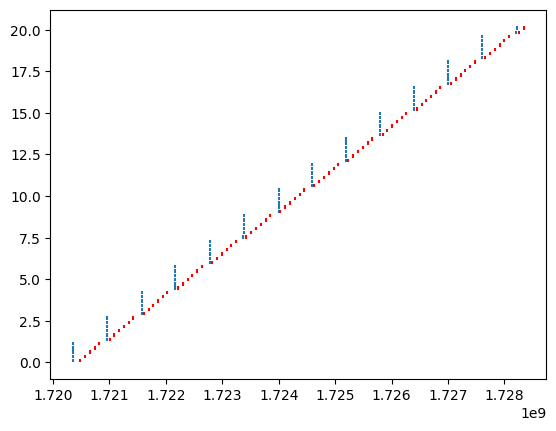

In [248]:
df = pd.DataFrame.from_dict(bounds).T
df.columns = ['start','end']
plt.vlines(df.start*1e-9,np.linspace(0,20,df.shape[0]),np.linspace(0,20,df.shape[0])+0.2)
plt.vlines(df.end*1e-9,np.linspace(0,20,df.shape[0]),np.linspace(0,20,df.shape[0])+0.2,color='red')

5it [01:01, 12.36s/it]


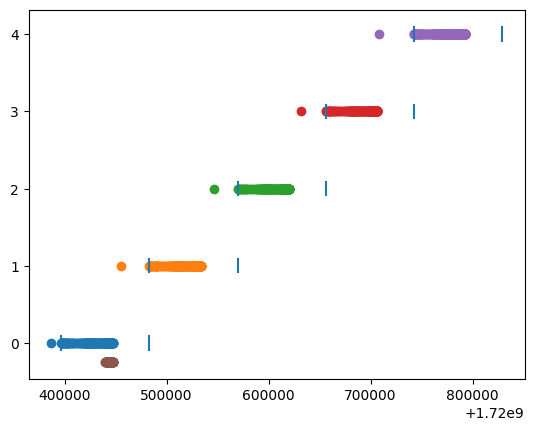

In [304]:
y = 0
for file in tqdm.tqdm(itertools.islice(sorted(glob.glob('../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/*.zst')),0,5)):
    data = db.DBNStore.from_file(file)
    counter = 0
    timestamps=[]
    instrument_map = db.common.symbology.InstrumentMap()
    instrument_map.insert_metadata(data.metadata)
    for mbo in data:
        instrument = instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_event*1e-9).date())

        cutoff = 1726916400
        is_sept_expiry = instrument in ('MESU4','ESU4')
        is_dec_expiry = instrument in ('MESZ4','ESZ4')

        if (mbo.ts_event * 1e-9 < cutoff and is_sept_expiry) or (mbo.ts_event * 1e-9 > cutoff and is_dec_expiry):
            if counter % 10000 == 0:
                timestamps.append(mbo.ts_event*1e-9)
            counter += 1
    plt.scatter(timestamps,[y for _ in timestamps])
    plt.vlines([data.metadata.start*1e-9,data.metadata.end*1e-9],y-0.1,y+0.1)
    y += 1

timestamps = []
counter = 0
found = False
with open('../output/databento/glbx-mdp3-20240708.csv','r') as f:
    for line in f:
        field = line.split(',')[1]
        if not found:
            if field=='ts_event':
                found = True
                continue
            else:
                purported_bounds = tuple(map(lambda t : t*1e-9,map(float,line.split(','))))
        if found:
            ts = float(field)*1e-9
            if counter%10000 == 0:
                timestamps.append(ts)
            if bounds is None:
                bounds = (ts,ts)
            bounds = (min(bounds[0],ts),max(bounds[1],ts))
            counter += 1
plt.scatter(timestamps, [-0.25 for _ in timestamps])
del timestamps

In [293]:
bounds = None
found = False
with open('../output/databento/glbx-mdp3-20240708.csv','r') as f:
    for line in f:
        field = line.split(',')[1]
        if not found:
            if field=='ts_event':
                found = True
                continue
            else:
                purported_bounds = tuple(map(lambda t : t*1e-9,map(float,line.split(','))))
        if found:
            ts = float(field)*1e-9
            if bounds is None:
                bounds = (ts,ts)
            bounds = (min(bounds[0],ts),max(bounds[1],ts))

In [295]:
bounds[1]-bounds[0]

7199.997522115707

In [296]:
purported_bounds[1]-purported_bounds[0]

86400.0

In [294]:
bounds,purported_bounds

((1720440000.0000646, 1720447199.9975867), (1720396800.0, 1720483200.0))

6857901it [00:16, 407575.06it/s]


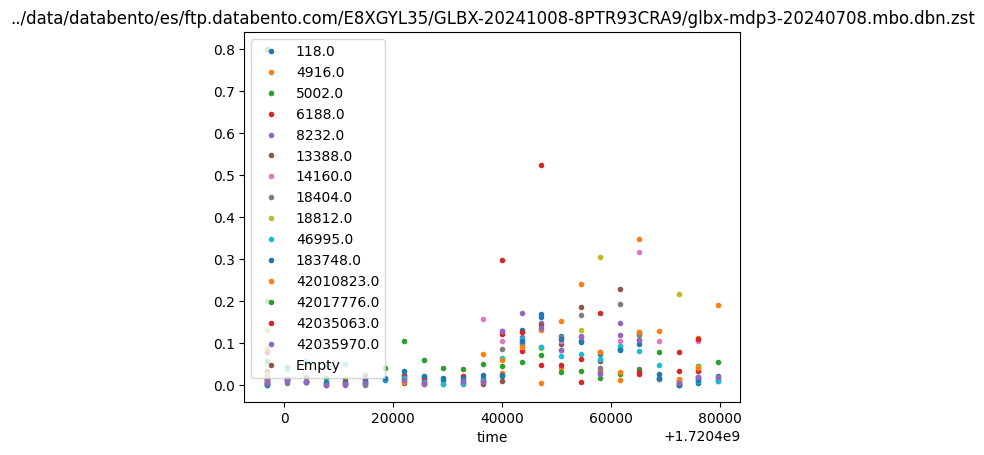

In [349]:
for file in sorted(glob.glob('../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/glbx-mdp3-*.mbo.dbn.zst'))[:1]:
    data = db.DBNStore.from_file(file)
    instrument_map = db.common.symbology.InstrumentMap()
    instrument_map.insert_metadata(data.metadata)
    pairs = Counter()
    for mbo in tqdm.tqdm(data):
        time = int(mbo.ts_recv*1e-9/60/60)*60*60
        instrument = instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_event*1e-9).date())
        pairs.update([(time,instrument,mbo.instrument_id)])
    df=pd.DataFrame(pairs.items()).apply(lambda x : pd.Series({'time':x[0][0],'ticker':x[0][1],'ticker_id':x[0][2],'freq':x[1]}),axis=1)
    for q,x in df.set_index('time').groupby('ticker_id').freq:
        (x/x.sum()).plot(label=q,marker='.',linestyle='')
    x=df[df.ticker_id.isna()].set_index('time').freq
    (x/x.sum()).plot(label='Empty',marker='.',linestyle='')
    plt.legend()
    plt.title(file)
    plt.show()

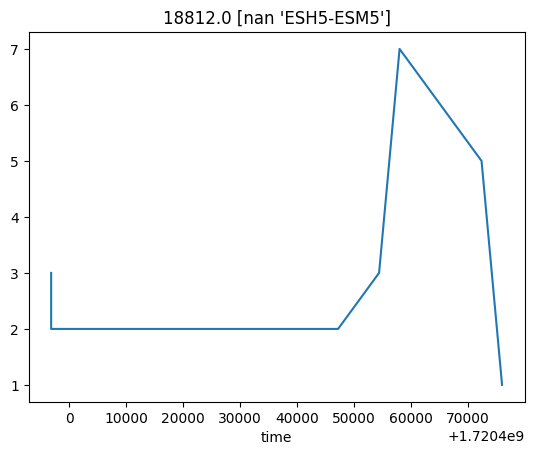

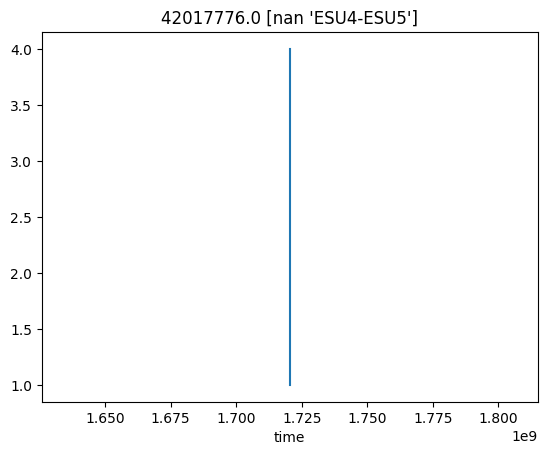

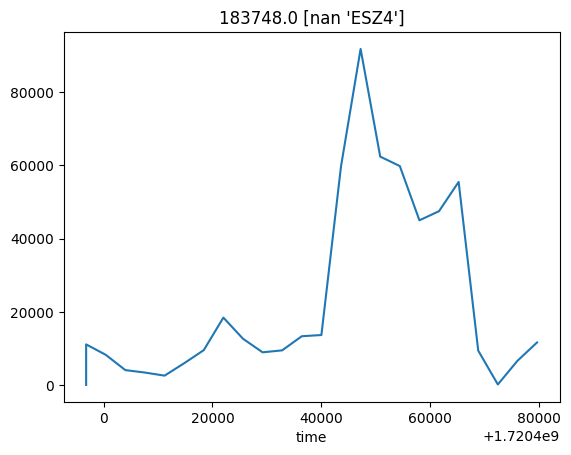

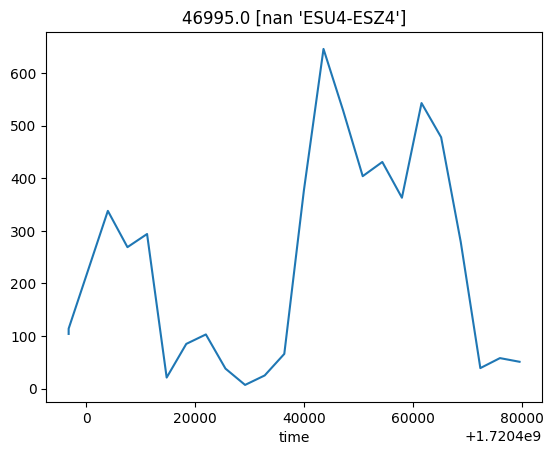

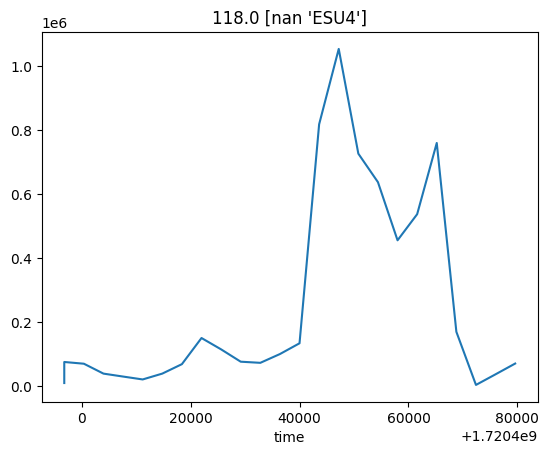

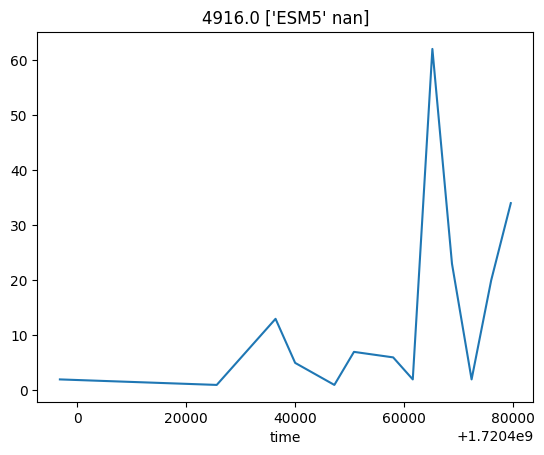

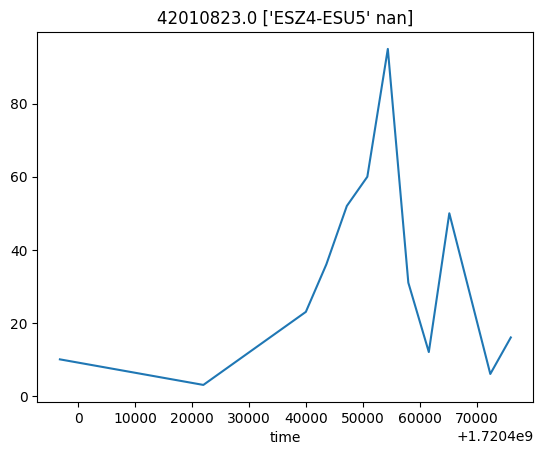

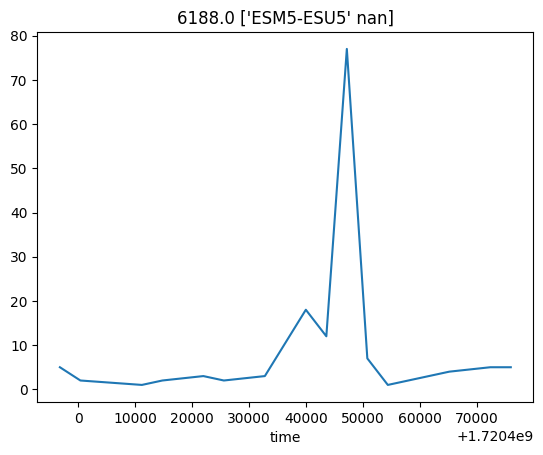

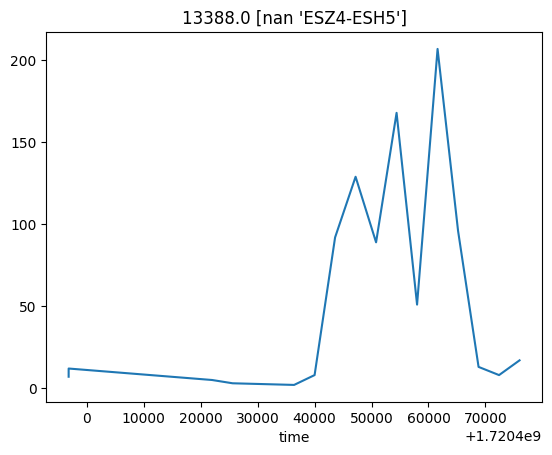

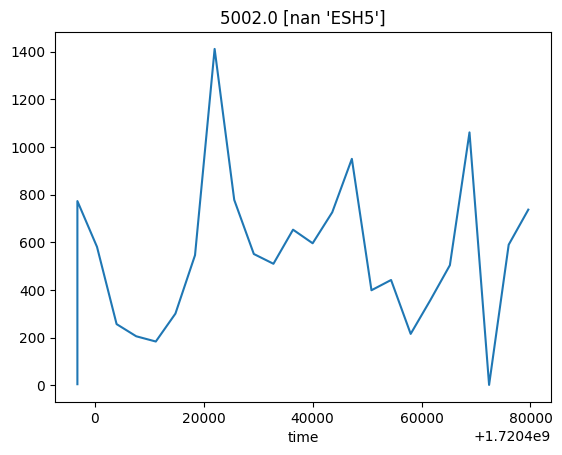

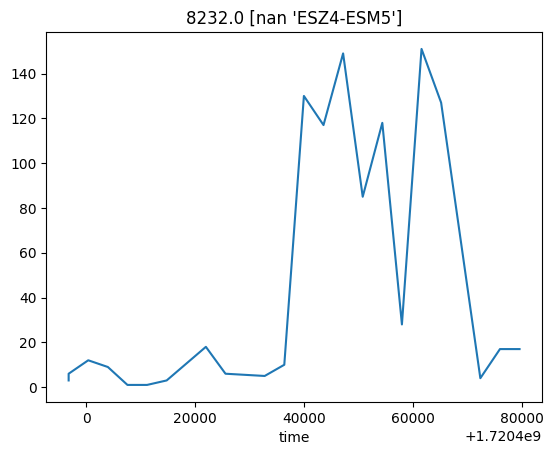

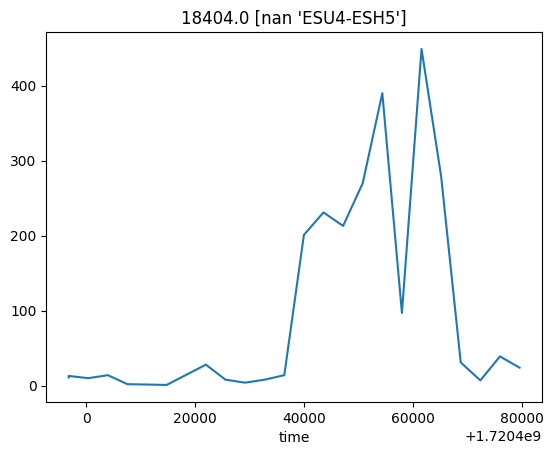

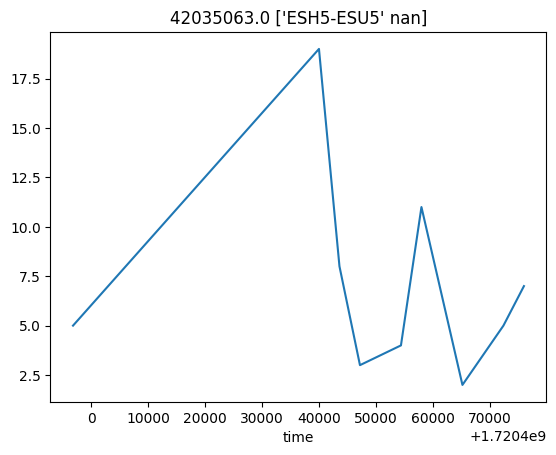

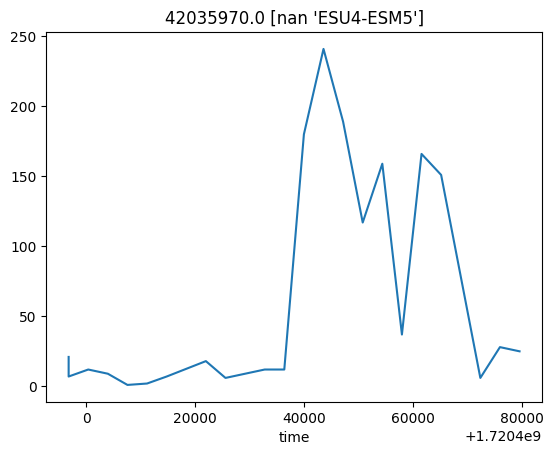

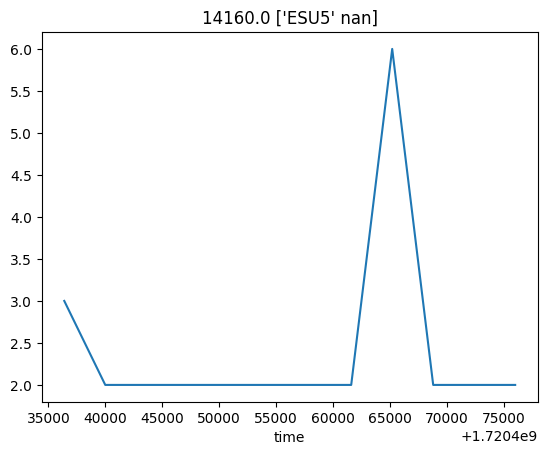

In [356]:
for tid in df.ticker_id.unique():
    df[df.ticker_id==tid].set_index('time').freq.plot()
    plt.title(f'{tid} {df[df.ticker_id==tid].ticker.unique()}')
    plt.show()

In [ ]:
for file in sorted(glob.glob('../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/glbx-mdp3-*.mbo.dbn.zst')):
    data = db.DBNStore.from_file(file)
    instrument_map = db.common.symbology.InstrumentMap()
    instrument_map.insert_metadata(data.metadata)
    pairs = Counter()
    for mbo in data:
        time = int(mbo.ts_recv*1e-9/60/60)*60*60
        instrument = instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_event*1e-9).date())
        pairs.update([(time,instrument)])
    df=pd.DataFrame(pairs.items()).apply(lambda x : pd.Series({'time':x[0][0],'ticker':x[0][1],'freq':x[1]}),axis=1)
    for q,x in df.set_index('time').groupby('ticker').freq:
        (x/x.sum()).plot(label=q,marker='.',linestyle='')
    x=df[df.ticker.isna()].set_index('time').freq
    (x/x.sum()).plot(label='Empty',marker='.',linestyle='')
    plt.legend()
    plt.title(file)
    plt.show()

5it [01:17, 15.55s/it]


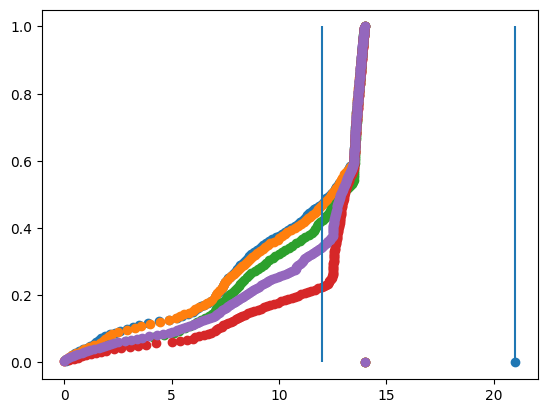

In [305]:
for file in tqdm.tqdm(itertools.islice(sorted(glob.glob('../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/*.zst')),0,5)):
    data = db.DBNStore.from_file(file)
    counter = 0
    timestamps=[]
    instrument_map = db.common.symbology.InstrumentMap()
    instrument_map.insert_metadata(data.metadata)
    for mbo in data:
        instrument = instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_event*1e-9).date())

        cutoff = 1726916400
        is_sept_expiry = instrument in ('MESU4','ESU4')
        is_dec_expiry = instrument in ('MESZ4','ESZ4')

        if (mbo.ts_event * 1e-9 < cutoff and is_sept_expiry) or (mbo.ts_event * 1e-9 > cutoff and is_dec_expiry):
            if counter % 10000 == 0:
                timestamps.append((mbo.ts_event*1e-9/60/60)%24)
            counter += 1
    plt.scatter(timestamps,np.linspace(0,1,len(timestamps)))
plt.vlines([12,21],0,1)
del timestamps

In [321]:
[x for x in instrument_map._data.values()]

[[MappingInterval(start_date=datetime.date(2024, 7, 12), end_date=datetime.date(2024, 7, 13), symbol='MESZ4-MESH5')],
 [MappingInterval(start_date=datetime.date(2024, 7, 12), end_date=datetime.date(2024, 7, 13), symbol='MESH5-MESU5')],
 [MappingInterval(start_date=datetime.date(2024, 7, 12), end_date=datetime.date(2024, 7, 13), symbol='MESZ4-MESU5')],
 [MappingInterval(start_date=datetime.date(2024, 7, 12), end_date=datetime.date(2024, 7, 13), symbol='MESM5')],
 [MappingInterval(start_date=datetime.date(2024, 7, 12), end_date=datetime.date(2024, 7, 13), symbol='MESU5')],
 [MappingInterval(start_date=datetime.date(2024, 7, 12), end_date=datetime.date(2024, 7, 13), symbol='MESU4-MESU5')],
 [MappingInterval(start_date=datetime.date(2024, 7, 12), end_date=datetime.date(2024, 7, 13), symbol='MESM5-MESU5')],
 [MappingInterval(start_date=datetime.date(2024, 7, 12), end_date=datetime.date(2024, 7, 13), symbol='MESZ4-MESM5')],
 [MappingInterval(start_date=datetime.date(2024, 7, 12), end_date=da

In [311]:
dir(instrument_map)

['SYMBOLOGY_RESOLVE_KEYS',
 'SYMBOLOGY_RESULT_KEYS',
 '__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_data',
 '_insert_interval',
 'clear',
 'insert_json',
 'insert_metadata',
 'insert_symbol_mapping_msg',
 'map_symbols_csv',
 'map_symbols_json',
 'resolve']

5it [00:50, 10.17s/it]


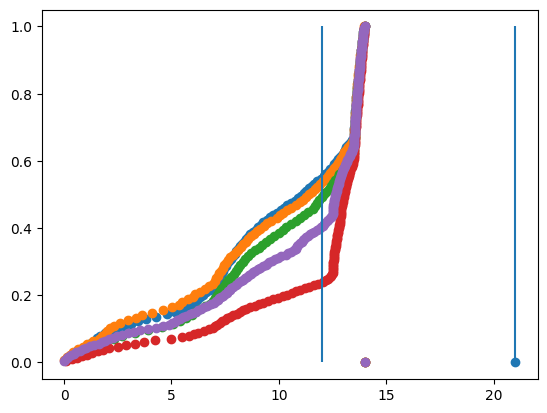

In [307]:
for file in tqdm.tqdm(itertools.islice(sorted(glob.glob('../data/databento/mes/ftp.databento.com/E8XGYL35/GLBX-20241008-PP9KBLT3CX/*.zst')),0,5)):
    data = db.DBNStore.from_file(file)
    counter = 0
    timestamps=[]
    instrument_map = db.common.symbology.InstrumentMap()
    instrument_map.insert_metadata(data.metadata)
    for mbo in data:
        instrument = instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_event*1e-9).date())

        cutoff = 1726916400
        is_sept_expiry = instrument in ('MESU4','ESU4')
        is_dec_expiry = instrument in ('MESZ4','ESZ4')

        if (mbo.ts_event * 1e-9 < cutoff and is_sept_expiry) or (mbo.ts_event * 1e-9 > cutoff and is_dec_expiry):
            if counter % 10000 == 0:
                timestamps.append((mbo.ts_event*1e-9/60/60)%24)
            counter += 1
    plt.scatter(timestamps,np.linspace(0,1,len(timestamps)))
plt.vlines([12,21],0,1)
del timestamps

In [249]:
metadata_bounds = dict()
for file in tqdm.tqdm(sorted(glob.glob('../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/*.zst'))):
    data = db.DBNStore.from_file(file)
    metadata_bounds[file] = (data.metadata.start,data.metadata.end)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 114.28it/s]


In [254]:
df.loc['../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/glbx-mdp3-20240806.mbo.dbn.zst']

start    1722902400000000000
end      1722988800000000000
Name: ../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/glbx-mdp3-20240806.mbo.dbn.zst, dtype: int64

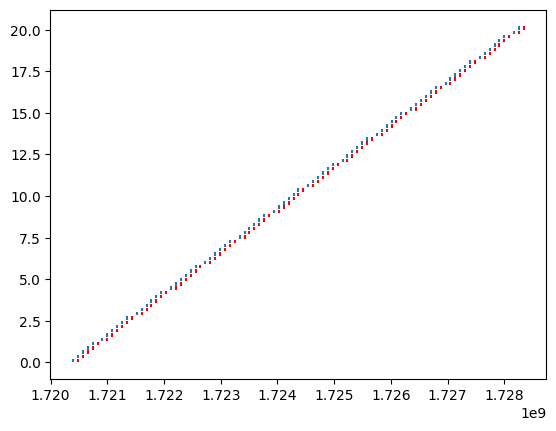

In [250]:
df = pd.DataFrame.from_dict(metadata_bounds).T
df.columns = ['start','end']
plt.vlines(df.start*1e-9,np.linspace(0,20,df.shape[0]),np.linspace(0,20,df.shape[0])+0.2)
plt.vlines(df.end*1e-9,np.linspace(0,20,df.shape[0]),np.linspace(0,20,df.shape[0])+0.2,color='red')

In [87]:
data = db.DBNStore.from_file('../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/glbx-mdp3-20240906.mbo.dbn.zst')
instrument_map = db.common.symbology.InstrumentMap()
instrument_map.insert_metadata(data.metadata)

begin,end = None,None
ts_prev = None
buckets = dict()
clear_times = set()
for mbo in data:
    instrument = instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_recv*1e-9).date())
    if instrument == 'ESU4' and not (mbo.flags & db.RecordFlags.F_BAD_TS_RECV):
        if mbo.action=='R':
            clear_times.add(mbo.ts_event)
        if begin is None:
            begin = float(mbo.ts_event)
        if end is None:
            end = float(mbo.ts_event)
        if ts_prev is not None:
            assert ts_prev <= mbo.ts_event, (ts_prev,mbo.ts_event)
        begin = min(float(mbo.ts_event),begin)
        end = max(float(mbo.ts_event),end)

        bucket = int(mbo.ts_event*1e-9/60)
        if bucket not in buckets:
            buckets[bucket]=0
        buckets[bucket]+=1
        
        ts_prev = mbo.ts_event

In [88]:
clear_times

set()

In [89]:
(max(buckets)-min(buckets))/60

13.983333333333333

In [90]:
for mbo in itertools.islice((x for x in data if instrument_map.resolve(x.instrument_id, datetime.datetime.fromtimestamp(x.ts_recv*1e-9).date())=='ESU4'),9035,9100):
    print(mbo.ts_event,mbo.order_id,mbo.action,mbo.instrument_id,mbo.size,mbo.side)

1725573606149659223 6413773191290 A 118 1 A
1725573606154669241 6413773191291 A 118 1 B
1725573606154670661 6413773191292 A 118 1 A
1725573606159681063 6413773191294 A 118 1 B
1725573606159682867 6413773191295 A 118 1 A
1725573606164693095 6413773191296 A 118 1 B
1725573606164694747 6413773191297 A 118 1 A
1725573606169705205 6413773191298 A 118 1 B
1725573606169707107 6413773191299 A 118 1 A
1725573606174717029 6413773191300 A 118 1 B
1725573606174718833 6413773191301 A 118 1 A
1725573606179729195 6413773191302 A 118 1 B
1725573606179734475 6413773191303 A 118 1 A
1725573606184741131 6413773191305 A 118 1 B
1725573606746580959 6413773191343 A 118 1 A
1725573607021752109 6413773191370 A 118 1 B
1725573607021758735 6413773191371 A 118 1 A
1725573607026758345 6413773191372 A 118 1 B
1725573607026760727 6413773191373 A 118 1 A
1725573607031769725 6413773191374 A 118 1 B
1725573607031771703 6413773191375 A 118 1 A
1725573607036781777 6413773191376 A 118 1 B
1725573607036783583 641377319137

<Axes: xlabel='bucket'>

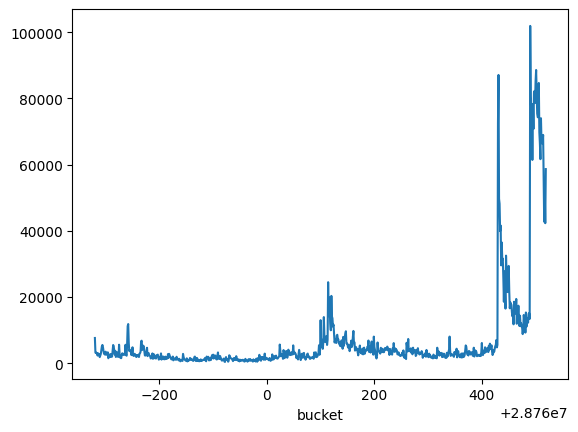

In [91]:
pd.DataFrame(buckets.items(),columns=['bucket','count']).set_index('bucket')['count'].plot()

In [76]:
buckets[min(buckets)]

528

In [17]:
(end-begin)*1e-9/60/60

25.998871535573336

In [227]:
folders = ["../data/databento/mes/ftp.databento.com/E8XGYL35/GLBX-20241008-PP9KBLT3CX/", "../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/"]
filenames = set([file.split('/')[-1] for folder in folders for file in glob.glob(f'{folder}/*.zst')])
print(filenames)
for filename in tqdm.tqdm(filenames):
    starts = set()
    for folder in folders:
        data = db.DBNStore.from_file(folder+filename)
        starts.add(data.metadata.start)
        print(data.metadata.start*1e-9,(data.metadata.end-data.metadata.start)*1e-9/60/60, ((data.metadata.start*1e-9)%(60*60*24))/60/60, (list(itertools.islice(data,0,1))[0].ts_event-data.metadata.start)*1e-9/60/60)
    assert len(starts)==1,filename
    print()

{'glbx-mdp3-20240721.mbo.dbn.zst', 'glbx-mdp3-20240905.mbo.dbn.zst', 'glbx-mdp3-20240908.mbo.dbn.zst', 'glbx-mdp3-20240712.mbo.dbn.zst', 'glbx-mdp3-20240925.mbo.dbn.zst', 'glbx-mdp3-20240807.mbo.dbn.zst', 'glbx-mdp3-20240915.mbo.dbn.zst', 'glbx-mdp3-20240930.mbo.dbn.zst', 'glbx-mdp3-20240920.mbo.dbn.zst', 'glbx-mdp3-20240901.mbo.dbn.zst', 'glbx-mdp3-20240811.mbo.dbn.zst', 'glbx-mdp3-20240821.mbo.dbn.zst', 'glbx-mdp3-20241003.mbo.dbn.zst', 'glbx-mdp3-20240711.mbo.dbn.zst', 'glbx-mdp3-20240927.mbo.dbn.zst', 'glbx-mdp3-20240823.mbo.dbn.zst', 'glbx-mdp3-20240726.mbo.dbn.zst', 'glbx-mdp3-20240729.mbo.dbn.zst', 'glbx-mdp3-20240924.mbo.dbn.zst', 'glbx-mdp3-20241001.mbo.dbn.zst', 'glbx-mdp3-20240815.mbo.dbn.zst', 'glbx-mdp3-20240813.mbo.dbn.zst', 'glbx-mdp3-20240718.mbo.dbn.zst', 'glbx-mdp3-20240730.mbo.dbn.zst', 'glbx-mdp3-20240723.mbo.dbn.zst', 'glbx-mdp3-20240802.mbo.dbn.zst', 'glbx-mdp3-20240828.mbo.dbn.zst', 'glbx-mdp3-20240714.mbo.dbn.zst', 'glbx-mdp3-20240822.mbo.dbn.zst', 'glbx-mdp3-20

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 978.96it/s]

1721520000.0 24.0 0.0 16.33940276047639
1721520000.0 24.0 0.0 16.33557141779861

1725494400.0 24.0 0.0 -83.99857346567195
1725494400.0 24.0 0.0 -83.9985975551925

1725753600.0 24.0 0.0 11.0694067786325
1725753600.0 24.0 0.0 11.06560866420028

1720742400.0 24.0 0.0 -1.9826556659347223
1720742400.0 24.0 0.0 -107.99887392991083

1727222400.0 24.0 0.0 -1.592679202211389
1727222400.0 24.0 0.0 -59.99866910451529

1722988800.0 24.0 0.0 -1.9826269357880555
1722988800.0 24.0 0.0 -59.627955801736945

1726358400.0 24.0 0.0 11.069323059469722
1726358400.0 24.0 0.0 11.065528978384723

1727654400.0 24.0 0.0 -11.998850508511945
1727654400.0 24.0 0.0 -11.998873822984724

1726790400.0 24.0 0.0 -7.4334652212491665
1726790400.0 24.0 0.0 -6.463996020100279

1725148800.0 24.0 0.0 11.069490450824167
1725148800.0 24.0 0.0 11.065688885860833

1723334400.0 24.0 0.0 11.06960723828639
1723334400.0 24.0 0.0 11.065792725839167

1724198400.0 24.0 0.0 -59.99867286332361
1724198400.0 24.0 0.0 -55.8231221787975

17279

In [7]:
instruments = dict()
for file in tqdm.tqdm(sorted(glob.glob('../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/*.zst'))):
    data = db.DBNStore.from_file(file)
    instrument_map = db.common.symbology.InstrumentMap()
    instrument_map.insert_metadata(data.metadata)
    print(file, {x for x in {instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_recv*1e-9).date()) for mbo in data} if x and '-' not in x and x[-1]=='4'})

  1%|██▌                                                                                                                                                                                                       | 1/79 [00:07<09:14,  7.11s/it]

../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/glbx-mdp3-20240708.mbo.dbn.zst {'ESZ4', 'ESU4'}


  1%|██▌                                                                                                                                                                                                       | 1/79 [00:13<18:05, 13.91s/it]

KeyboardInterrupt



In [ ]:
instruments = dict()
for file in tqdm.tqdm(sorted(glob.glob('../data/databento/mes/ftp.databento.com/E8XGYL35/GLBX-20241008-PP9KBLT3CX/*.zst'))):
    data = db.DBNStore.from_file(file)
    instrument_map = db.common.symbology.InstrumentMap()
    instrument_map.insert_metadata(data.metadata)
    print(file, {x for x in {instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_recv*1e-9).date()) for mbo in data} if x and '-' not in x and x[-1]=='4'})

In [ ]:
instruments = dict()
for file in tqdm.tqdm(sorted(glob.glob('../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/*.zst'))):
    data = db.DBNStore.from_file(file)
    instrument_map = db.common.symbology.InstrumentMap()
    instrument_map.insert_metadata(data.metadata)
    for mbo in data:
        instrument = instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_recv*1e-9).date())
        if instrument not in instruments:
            instruments[instrument] = 0
        instruments[instrument] += 1
    print(instruments)

# Event Counts

In [92]:
buckets = dict()
for file in tqdm.tqdm(sorted(glob.glob('../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/*.zst'))):
    data = db.DBNStore.from_file(file)
    for mbo in data:
        instrument = instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_recv*1e-9).date())
        if instrument == 'ESU4' and not (mbo.flags & db.RecordFlags.F_BAD_TS_RECV):
            bucket = int(mbo.ts_event * 1e-9 / 60) * 60
            if bucket not in buckets:
                buckets[bucket] = 0
            buckets[bucket] += 1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [19:39<00:00, 14.93s/it]


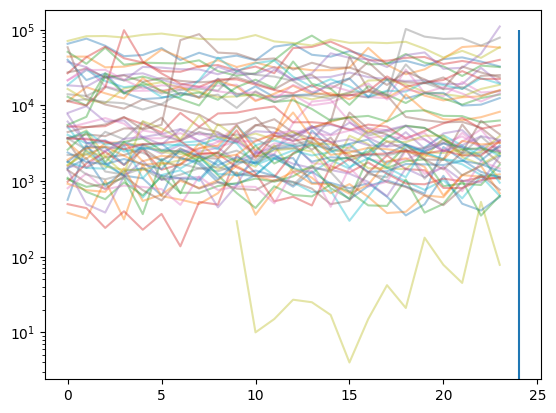

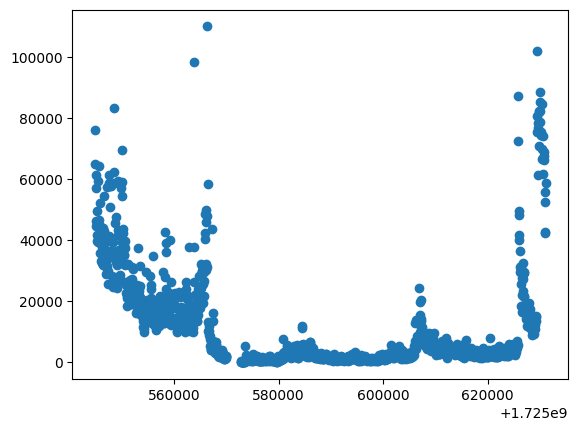

In [105]:
df = pd.DataFrame(buckets.items(),columns=['bucket','count'])
for _,x in df.groupby((df.bucket/(60*24)).astype(int)):
    plt.plot((x.bucket%(60*24))/60, x['count'], alpha=0.4)
plt.vlines([24],0,100000)
plt.yscale('log')
plt.show()

plt.scatter(*zip(*buckets.items()))
plt.show()

<Axes: >

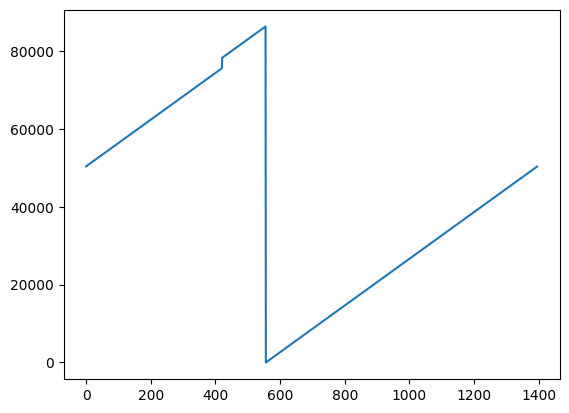

In [115]:
(df.bucket%(60*60*24)).plot()

<Axes: xlabel='bucket'>

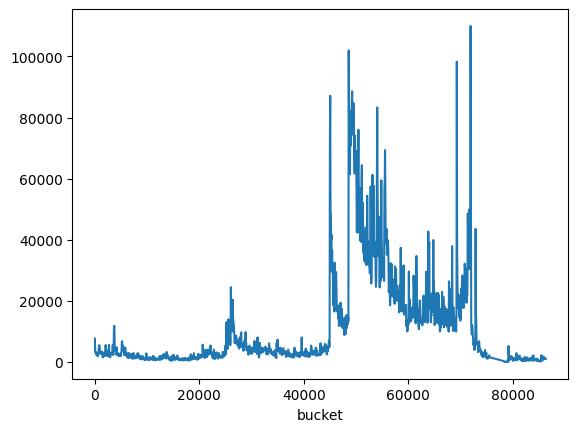

In [109]:
df.groupby(df.bucket%(60*60*24)).mean()['count'].plot()

## Trades

In [116]:
buckets = dict()
for file in tqdm.tqdm(sorted(glob.glob('../data/databento/es/ftp.databento.com/E8XGYL35/GLBX-20241008-8PTR93CRA9/*.zst'))):
    data = db.DBNStore.from_file(file)
    for mbo in data:
        instrument = instrument_map.resolve(mbo.instrument_id, datetime.datetime.fromtimestamp(mbo.ts_recv*1e-9).date())
        if mbo.action=='T' and instrument == 'ESU4' and not (mbo.flags & db.RecordFlags.F_BAD_TS_RECV):
            bucket = int(mbo.ts_event * 1e-9 / 60) * 60
            if bucket not in buckets:
                buckets[bucket] = 0
            buckets[bucket] += 1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [19:47<00:00, 15.03s/it]


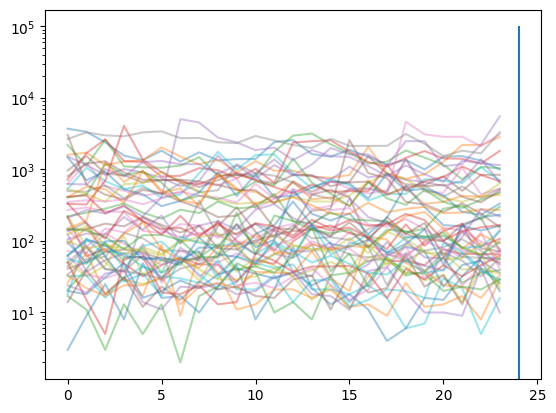

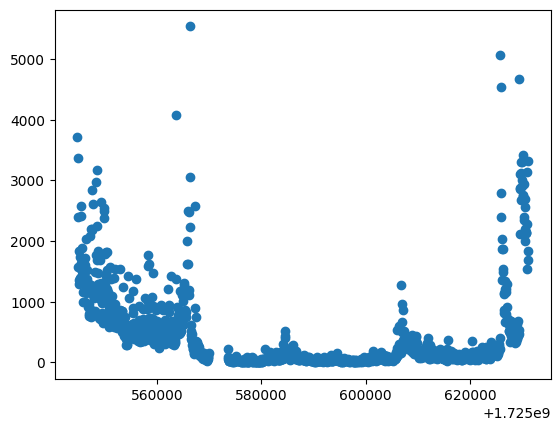

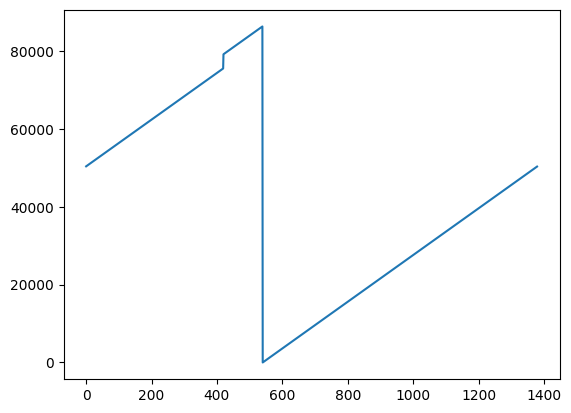

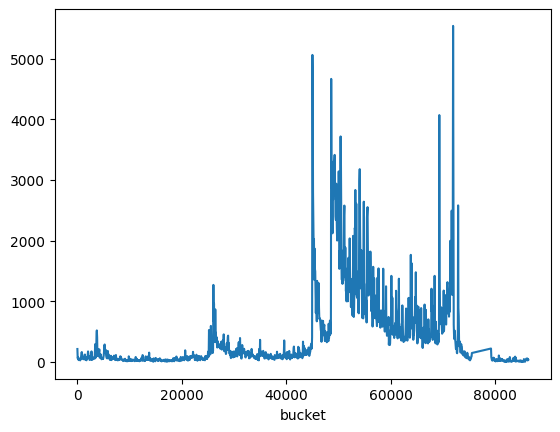

In [117]:
df = pd.DataFrame(buckets.items(),columns=['bucket','count'])
for _,x in df.groupby((df.bucket/(60*24)).astype(int)):
    plt.plot((x.bucket%(60*24))/60, x['count'], alpha=0.4)
plt.vlines([24],0,100000)
plt.yscale('log')
plt.show()

plt.scatter(*zip(*buckets.items()))
plt.show()

(df.bucket%(60*60*24)).plot()
plt.show()

df.groupby(df.bucket%(60*60*24)).mean()['count'].plot()
plt.show()

# Other Stats

In [264]:
for mbo in itertools.islice(data,50000,50300):
    if mbo.order_id == 6413463834390:
        print(mbo)
        #print(mbo, mbo.flags & db.RecordFlags.F_LAST)

MboMsg { hd: RecordHeader { length: 14, rtype: Mbo, publisher_id: GlbxMdp3Glbx, instrument_id: 118, ts_event: 1720658286819545007 }, order_id: 6413463834390, price: 5681.500000000, size: 10, flags: 0, channel_id: 0, action: 'T', side: 'A', ts_recv: 1720658286819963134, ts_in_delta: 15492, sequence: 17260442 }


In [307]:
from collections import Counter

In [308]:
Counter(map(lambda m : m.instrument_id,data))

Counter({118: 14051350,
         183748: 1095101,
         5002: 54932,
         46995: 10457,
         18404: 5402,
         42035970: 2107,
         8232: 1957,
         13388: 1780,
         4916: 1537,
         42010823: 1436,
         42035063: 487,
         14160: 442,
         6188: 419,
         42017776: 41,
         18812: 26})

In [272]:
for mbo in data:
    if mbo.order_id == 6413463833727 and mbo.instrument_id==118:
        print(mbo.instrument_id, mbo.ts_event, mbo.ts_recv, mbo.order_id, mbo.action, mbo.side, mbo.size, mbo.price, mbo.flags)

118 1720658159654227819 1720658159654359622 6413463833727 A B 5 5680750000000 130
118 1720658185133673693 1720658185133803498 6413463833727 M B 5 5681000000000 130
118 1720658236753695135 1720658236753833670 6413463833727 M B 5 5681250000000 130
118 1720658246773706565 1720658246774321466 6413463833727 M B 5 5681500000000 130
118 1720658286819545007 1720658286819963134 6413463833727 F B 1 5681500000000 0
118 1720658286819545007 1720658286819973604 6413463833727 M B 4 5681500000000 130
118 1720658303449401769 1720658303449701653 6413463833727 F B 1 5681500000000 0
118 1720658303449401769 1720658303449708999 6413463833727 M B 3 5681500000000 130
118 1720658304401941323 1720658304402161416 6413463833727 F B 2 5681500000000 0
118 1720658304401941323 1720658304402168276 6413463833727 M B 1 5681500000000 130
118 1720658334506579261 1720658334506834119 6413463833727 F B 1 5681500000000 0
118 1720658334506579261 1720658334506840729 6413463833727 C B 1 5681500000000 130


In [270]:
for mbo in itertools.islice(data,50000,50300):
    if mbo.ts_event == 1720658286819545007:
        print(mbo.instrument_id, mbo.ts_event, mbo.ts_recv, mbo.order_id, mbo.action, mbo.side, mbo.size, mbo.price, mbo.flags)
        #print(mbo, mbo.flags & db.RecordFlags.F_LAST)

118 1720658286819545007 1720658286819963134 6413463834390 T A 10 5681500000000 0
118 1720658286819545007 1720658286819963134 6413463834227 F B 1 5681500000000 0
118 1720658286819545007 1720658286819963134 6413463834237 F B 2 5681500000000 0
118 1720658286819545007 1720658286819963134 6413463834238 F B 1 5681500000000 0
118 1720658286819545007 1720658286819963134 6413463834242 F B 1 5681500000000 0
118 1720658286819545007 1720658286819963134 6413463834261 F B 4 5681500000000 0
118 1720658286819545007 1720658286819963134 6413463833727 F B 1 5681500000000 0
118 1720658286819545007 1720658286819973604 6413463834227 C B 1 5681500000000 0
118 1720658286819545007 1720658286819973604 6413463834237 C B 2 5681500000000 0
118 1720658286819545007 1720658286819973604 6413463834238 C B 1 5681500000000 0
118 1720658286819545007 1720658286819973604 6413463834242 C B 1 5681500000000 0
118 1720658286819545007 1720658286819973604 6413463834261 C B 4 5681500000000 0
118 1720658286819545007 172065828681997

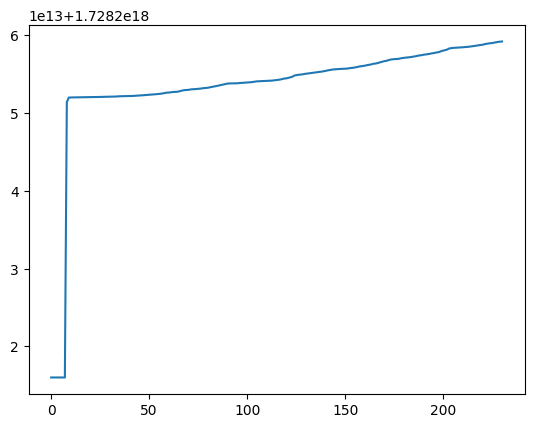

In [171]:
plt.plot(times_list)

In [172]:
max_diff = (0,None)
cur_time = None
pairs = []
for mbo in data:
    if cur_time is None:
        cur_time = mbo.ts_recv
    else:
        timedelta, cur_time = mbo.ts_recv - cur_time, mbo.ts_recv
        pair = (timedelta*1e-9 / 60/60,cur_time)
        if pair > max_diff:
            pairs.append(pair)
            max_diff = pair
max_diff

(8.998735717527222, 1728248400361796387)

In [146]:
df[(df.action=='T') & (~df.instrument.isna())]

,instrument,timestamp,action,side,size,price,ts_delta,bq,bp,aq,ap,is_last
timestamp,,,,,,,,,,,,


In [352]:
df = pd.read_csv('../output/databento/glbx-mdp3-20241006.csv',nrows=1000000)
df = df.set_index(df.timestamp)

/tmp/ipykernel_47647/137176903.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../output/databento/glbx-mdp3-20241006.csv',nrows=1000000)


In [132]:
df[(~df.instrument.isna()) & ~(df.bp.isna() & df.ap.isna())].index.max() - df[(~df.instrument.isna()) & ~(df.bp.isna() & df.ap.isna())].index.min()

np.float64(0.26216936111450195)

<Axes: xlabel='timestamp'>

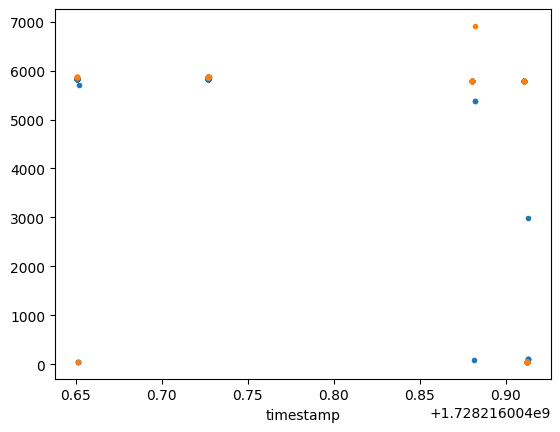

In [133]:
df[~df.instrument.isna()].bp.plot(marker='.',linestyle='')
df[~df.instrument.isna()].ap.plot(marker='.',linestyle='')

<Axes: xlabel='timestamp'>

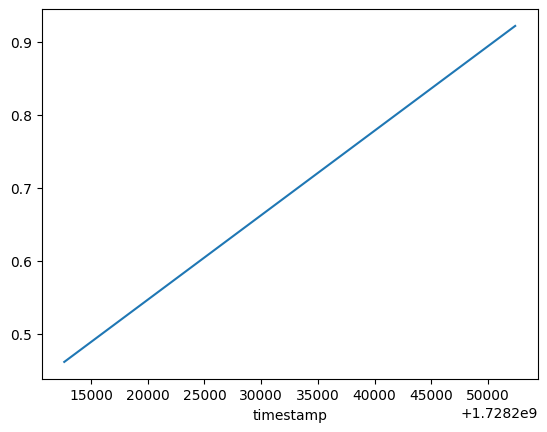

In [98]:
((df.timestamp%(60*60*24))/(60*60*24)).plot()

In [90]:
df[['action','side']].sum(axis=1).unique()

array(['RN', 'AB', 'AA', 'CB', 'CA', 'MA', 'MB', 'TN', 'FN', 'TA', 'FB',
       'TB', 'FA'], dtype=object)

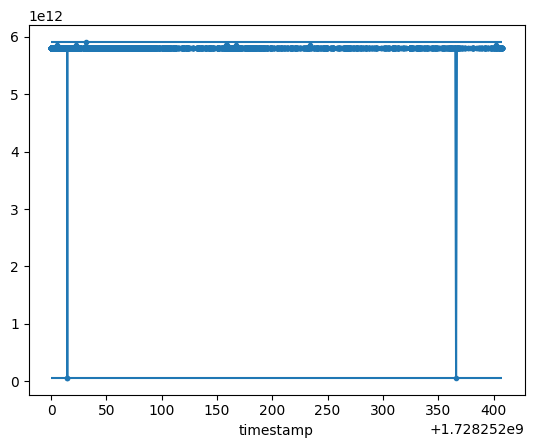

In [86]:
df[df.action=='T'].price.plot(marker='.')
plt.hlines([],df[df.action=='T'].index.min(),df[df.action=='T'].index.max())

In [339]:
df[(df.instrument=='ESH5') & (df.action=='T')].price.mean() / 10000 / 10000 / 10000

nan

In [342]:
df[(df.instrument=='ESZ4') & (df.action=='T')].price.mean() / 10000 / 10000 / 10000

nan

In [377]:
for ins in df.instrument.unique():
    print(ins, df[(df.instrument==ins) & (df.action=='T')].price.mean() / 10000 / 10000 / 10000)

ESU6 nan
ESZ9 nan
ESM7 nan
ESZ5 nan
ESU5 nan
ESU8 nan
ESH9 nan
ESZ8 nan
ESM9 nan
ESZ4 nan
ESU7 nan
ESM8 nan
ESH5 nan
ESU9 nan
ESH8 nan
ESH7 nan
ESM5 nan
ESZ7 nan
ESZ6 nan
ESH6 nan
ESM6 nan
ESZ5-ESM6 nan
ESZ4-ESM5 nan
ESH6-ESM6 nan
ESZ4-ESZ5 nan
ESM5-ESH6 nan
ESU5-ESH6 nan
ESU6-ESZ6 nan
ESZ5-ESH6 nan
ESH5-ESZ5 nan
ESH5-ESH6 nan
ESU5-ESZ5 nan
ESH5-ESM5 nan
ESM5-ESU5 nan
ESM6-ESU6 nan
ESZ4-ESU5 nan
ESU5-ESM6 nan
ESH6-ESU6 nan
ESH5-ESU5 nan
ESM5-ESZ5 nan
ESZ4-ESH5 nan
MESZ4 nan
MESZ5 nan
MESH5 nan
MESU5 nan
MESM5 nan
MESU5-MESZ5 nan
MESZ4-MESH5 nan
MESM5-MESU5 nan
MESZ4-MESZ5 nan
MESZ4-MESM5 nan
MESH5-MESU5 nan
MESZ4-MESU5 nan
MESH5-MESM5 nan
MESH5-MESZ5 nan
MESM5-MESZ5 nan
nan nan


In [53]:
df.instrument.unique()

array(['ESU6', 'ESZ9', 'ESM7', 'ESZ5', 'ESU5', 'ESU8', 'ESH9', 'ESZ8',
       'ESM9', 'ESZ4', 'ESU7', 'ESM8', 'ESH5', 'ESU9', 'ESH8', 'ESH7',
       'ESM5', 'ESZ7', 'ESZ6', 'ESH6', 'ESM6', 'ESZ5-ESM6', 'ESZ4-ESM5',
       'ESH6-ESM6', 'ESZ4-ESZ5', 'ESM5-ESH6', 'ESU5-ESH6', 'ESU6-ESZ6',
       'ESZ5-ESH6', 'ESH5-ESZ5', 'ESH5-ESH6', 'ESU5-ESZ5', 'ESH5-ESM5',
       'ESM5-ESU5', 'ESM6-ESU6', 'ESZ4-ESU5', 'ESU5-ESM6', 'ESH6-ESU6',
       'ESH5-ESU5', 'ESM5-ESZ5', 'ESZ4-ESH5', 'MESZ4', 'MESZ5', 'MESH5',
       'MESU5', 'MESM5', 'MESU5-MESZ5', 'MESZ4-MESH5', 'MESM5-MESU5',
       'MESZ4-MESZ5', 'MESZ4-MESM5', 'MESH5-MESU5', 'MESZ4-MESU5',
       'MESH5-MESM5', 'MESH5-MESZ5', 'MESM5-MESZ5', nan], dtype=object)

In [54]:
df.action.unique()

array(['R', 'A', 'C', 'M', 'T', 'F'], dtype=object)

In [30]:
df.side.unique()

array(['N', 'B', 'A'], dtype=object)

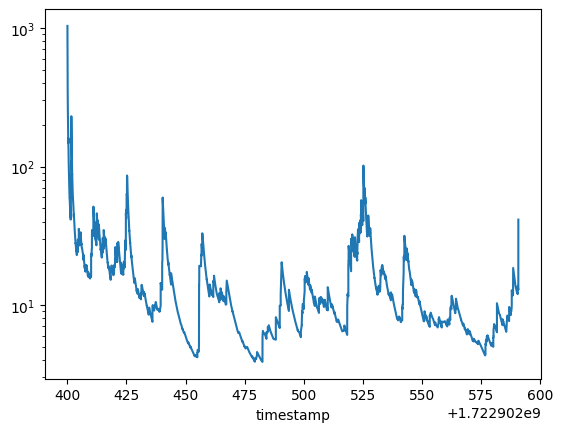

In [23]:
(1/df[df.action=='T'].timestamp.diff().rolling(50).mean()).plot()
plt.yscale('log')

<Axes: xlabel='timestamp'>

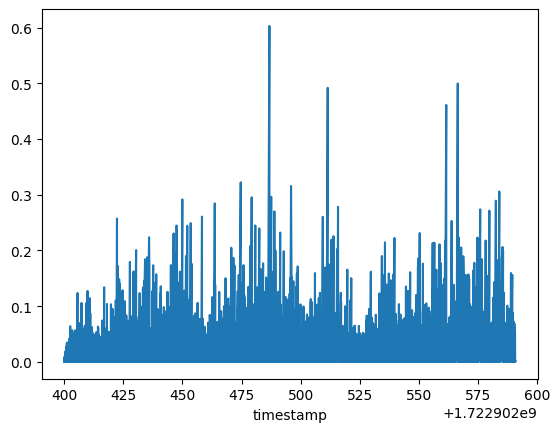

In [8]:
df.timestamp.diff().plot()

In [ ]:
df['bp'] = df.bp.astype(float)

In [66]:
df[df.bp == df.bp.min()]

,instrument,timestamp,action,side,size,ts_delta,bq,bp,aq,ap,is_last
timestamp,,,,,,,,,,,
1.725459e+09,ESH5-ESM5,1.725459e+09,T,A,1,13511,51,50.75,2,51.85,False
1.725481e+09,ESH5-ESM5,1.725481e+09,T,A,1,14762,1,50.75,2,51.10,False


<Axes: xlabel='timestamp'>

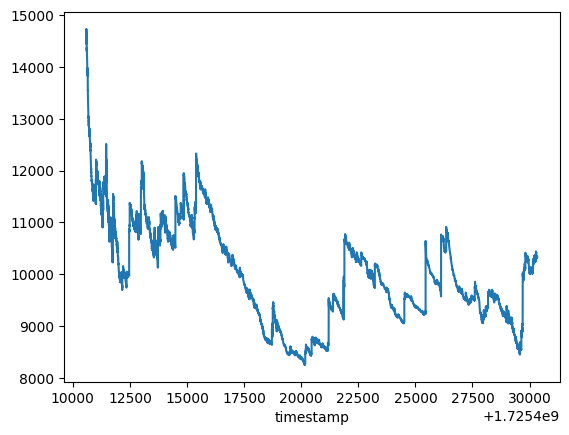

In [63]:
(1/df.head(80000).timestamp.diff()).ewm(span=10000).mean().tail(70000).plot()

<Axes: xlabel='timestamp'>

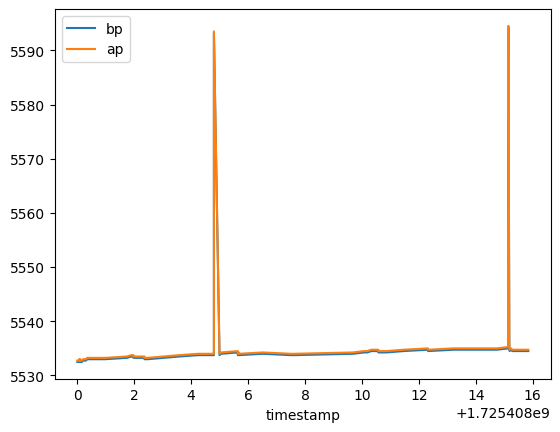

In [35]:
df[df.instrument=='ESH5-ESM5'][['bp','ap']].head(100).plot()

In [7]:
df.timestamp.max()-df.timestamp.min()

np.float64(86399.9288315773)